# Convergence Study for RegHCsTriple Infrastructure with `MMSCaseExpSin`

This notebook investigates the convergence properties of the RegHCsTriple infrastructure by performing:

1. Spatial convergence analysis (halving grid sizes)
2. Temporal convergence analysis (halving Δt)

We'll use the Method of Manufactured Solutions (MMS) to verify the expected convergence rates.

In [8]:
# Add "src/" to the Python path to import project modules
import sys
sys.path.append('src')

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import List, Tuple
import notebook_studies_helpers as nbh

# Import project modules
import prob1base as p1
import prob1_mms_cases as p1mc
import mms_trial_utils as mtu
from utils_for_testing import observed_rates_report

# Configure plotting
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Model Constants

Define model constants for this convergence study. We maintain a local copy of constants for better isolation.

In [2]:
# Local copy of model constants (copied from prob1base.py)
R0_study: float = 8.3144621
Ea_study: float = 1.60217662e-19

study_model_consts = p1.ModelConsts(
    R0=R0_study,
    Ea=Ea_study,
    K1=1e-3,
    K2=1e-3,
    K3=1e-3,
    K4=1e-3,
    DT=1e-3,
    Dl_max=1e-5,
    phi_l=1e-5,
    gamma_T=1e-9,
    Kd=1e-2,
    Sd=1,
    Dd_max=1e-6,
    phi_d=1e-5,
    phi_T=Ea_study / R0_study,
    r_sp=5e-2,
    T_ref=300,
)

# Create model using our constants
model = p1.DefaultModel02(mc=study_model_consts)

## MMS Case Selection

For this study, we'll use the `MMSCaseExpSin` case: smooth solution with sinusoidal behavior.

In [3]:
# Define MMS case class for this study
MMS_CASE_CLASS = p1mc.MMSCaseExpSin

# Create a sample MMS case (for visualization)
sample_grid = p1.make_uniform_grid(N=32, M=32)
mms_case_for_plot = MMS_CASE_CLASS(grid=sample_grid, model=model)

# Display the MMS case characteristics
print(f"Selected MMS case: {MMS_CASE_CLASS.__name__}")
print(f"Description: {MMS_CASE_CLASS.__doc__ if MMS_CASE_CLASS.__doc__ else 'No description available'}")

Selected MMS case: MMSCaseExpSin
Description: 
    Objeto com funções e dados exatos. Inclui solução exata e também funções
    de modelo. Aqui, as soluções são:

        Cp(t) = Cp(0) exp(∫₀ᵗ (-K1 (1 + Cl(s)) - K2 T(s)) ds)
        T(t) = exp(-2 π² D_T) W
        Cl(t) = -exp(-t) * W
        Cd(t) = -Cl(t) = exp(-t) W
        Cs(t) = Cs(0) exp(∫₀ᵗ (- Kd (Sd - Cd(s)) (1 + Cl(s)) ds)

    sendo

        W(x,y) = Sin(π x) Sin(π y)
    


## Visualize MMS Solution

Visualization of the MMS solution and the regularized Heaviside function.

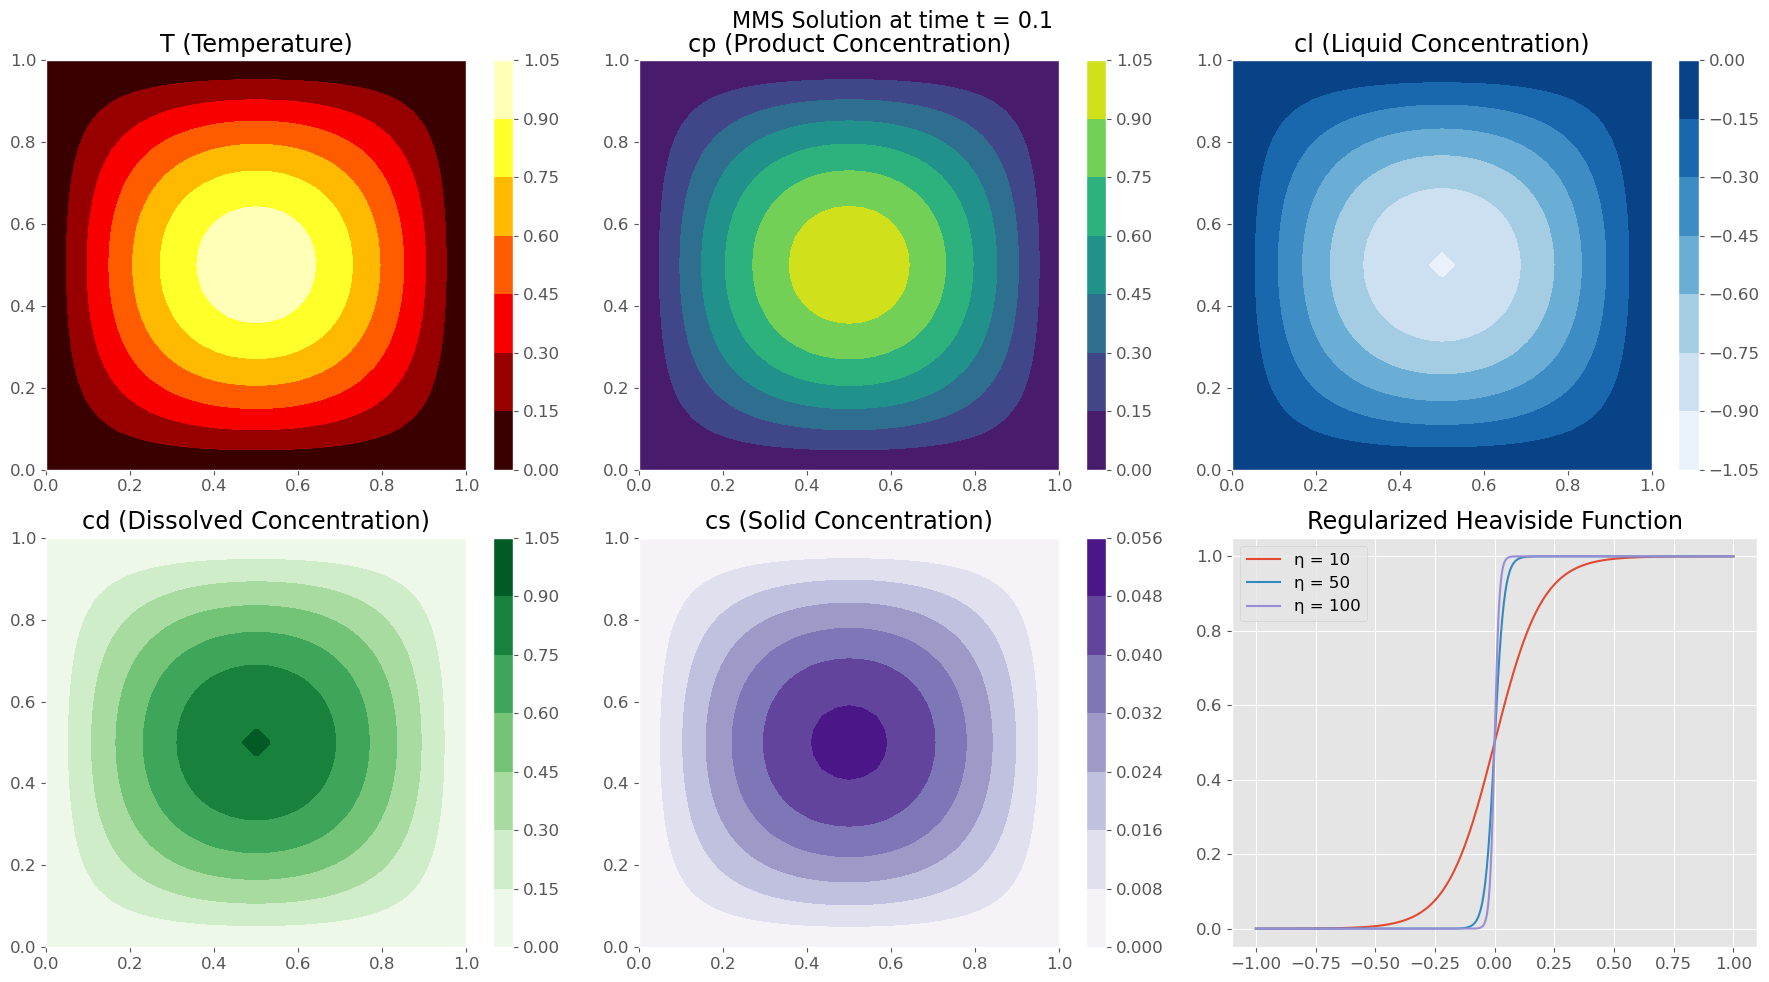

In [4]:
# Visualize the MMS solution at time t=0.1
nbh.visualize_mms_solution(mms_case_for_plot, time_point=0.1)

## Spatial Convergence Study

In this section, we'll study spatial convergence by:

1. Using progressively refined grids (halving grid sizes).
2. Measuring the error against the exact MMS solution.
3. Calculating the observed convergence rates using the three-point formula.

Our results say we expect second-order convergence (rate ≈ 2.0).

Grid sizes for study: [2, 4, 8, 16, 32, 64, 128, 256]

=== Spatial Convergence Study ===

Running simulation with grid size 2x2
  Completed in 0.010660648346 seconds
  Overall error: 1.942652829989e-05
  Per-variable errors:
    cp: 5.117412049671e-11
    T: 1.942592978811e-05
    cl: 1.502360035846e-07
    cd: 2.613030168737e-08
    cs: 4.099111328149e-11

Running simulation with grid size 4x4
  Completed in 0.018038511276 seconds
  Overall error: 5.197056624911e-06
  Per-variable errors:
    cp: 1.256907309773e-11
    T: 5.196897393606e-06
    cl: 8.361385539808e-09
    cd: 3.981368407828e-08
    cs: 2.229664720872e-11

Running simulation with grid size 8x8
  Completed in 0.013946056366 seconds
  Overall error: 1.322695968641e-06
  Per-variable errors:
    cp: 2.633417906387e-11
    T: 1.321626073073e-06
    cl: 3.027867380598e-08
    cd: 4.373041467431e-08
    cs: 2.201839078094e-11

Running simulation with grid size 16x16
  Completed in 0.023700475693 seconds
  Overall error: 3.372

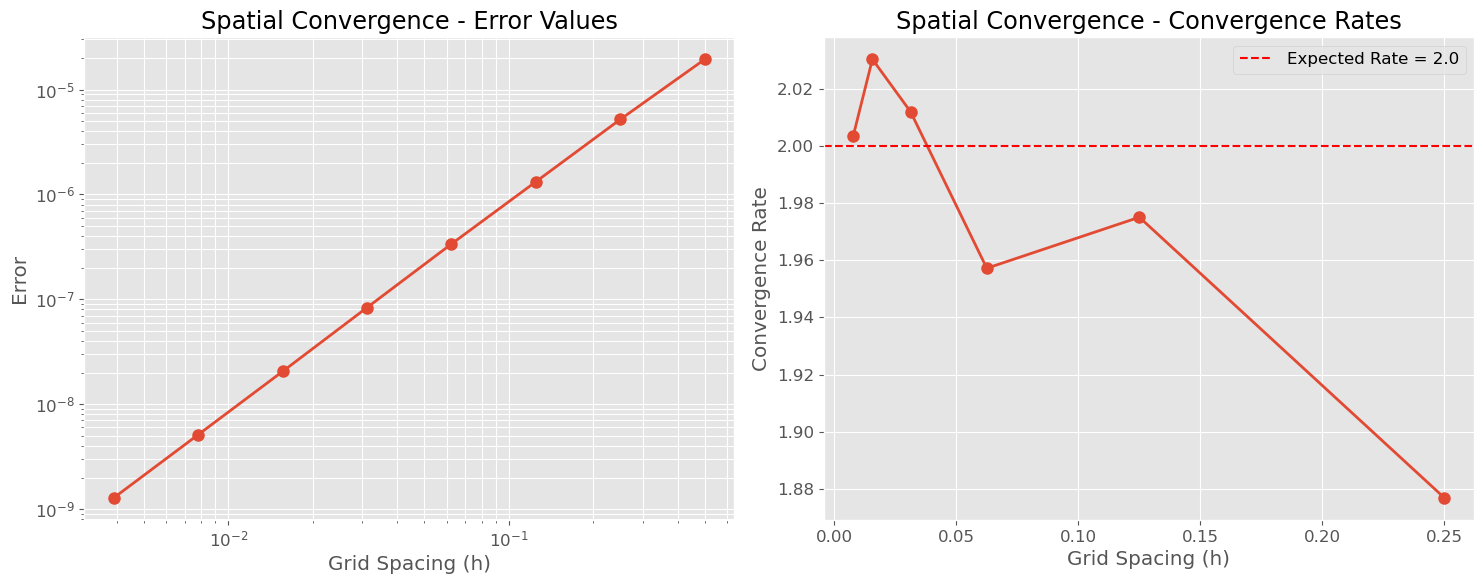

In [5]:
# Set up parameters for spatial convergence study
REGULARIZATION_FACTOR = 50.0  # η parameter for regularized Heaviside
BASE_GRID_SIZE = 2
REFINEMENT_LEVELS = 8

# Generate grid sizes (halving)
grid_sizes = [BASE_GRID_SIZE * (2**i) for i in range(REFINEMENT_LEVELS)]
print(f"Grid sizes for study: {grid_sizes}")

# Final simulation time (short to save computation time)
Tf = 0.01

# Initialize storage for results
spatial_errors = []
grid_h_values = [1.0/grid_size for grid_size in grid_sizes]  # Grid spacing

# Run simulations for each grid size
print("\n=== Spatial Convergence Study ===")
for i, grid_size in enumerate(grid_sizes):
    print(f"\nRunning simulation with grid size {grid_size}x{grid_size}")

    h = 1.0/grid_size
    DT_FIXED = (h ** 1.5) # O(Δt²) temporal convergence means time-error is O(h³) for Δt = h^{1.5}.
    
    # Create grid
    grid = p1.make_uniform_grid(N=grid_size, M=grid_size)
    
    # Create MMS case
    mms_case_for_plot = MMS_CASE_CLASS(grid=grid, model=model)
    
    # Set up RegHCsTriple infrastructure
    mms_trial = mtu.MMSTrial(
        grid=grid,
        model=model,
        mms_case_cls=MMS_CASE_CLASS,
        field_cls=p1.SemiDiscreteField_RegHCsTriple,
        forcing_terms_cls=p1.ForcingTerms_RegHCsTriple,
        integrator_cls=p1.P_ModifiedEuler_C_Trapezoidal_TimeIntegrator_RegHCsTriple, 
        forcing_terms_params={"regularization_factor": REGULARIZATION_FACTOR},
        field_params={"regularization_factor": REGULARIZATION_FACTOR},
        integrator_params={"regularization_factor": REGULARIZATION_FACTOR}
    )
    
    # Run the simulation and collect error
    start_time = time.time()
    error_summary = mms_trial.run_for_errors(Tf=Tf, dt=DT_FIXED)
    end_time = time.time()
    
    # Extract the overall combined error
    error = error_summary.overall_combined_error
    spatial_errors.append(error)
    
    print(f"  Completed in {end_time - start_time:.12f} seconds")
    print(f"  Overall error: {error:.12e}")
    print(f"  Per-variable errors:")
    for var, err in error_summary.per_variable_sup_errors.items():
        print(f"    {var}: {err:.12e}")

# Report on convergence rates (expecting rate of 2.0 for second-order accuracy)
spatial_rates, spatial_success = nbh.report_on_rates(
    errors=spatial_errors,
    expected_rate=2.0,
    tolerance=0.3,  # Allow some tolerance due to regularization effects
    title="Spatial Convergence Results"
)

# Plot results
nbh.plot_errors_and_rates(
    errors=spatial_errors,
    rates=spatial_rates,
    x_values=grid_h_values,
    x_label='Grid Spacing (h)',
    title='Spatial Convergence',
    expected_rate=2.0
)

# Save results for later reference
spatial_results = {
    'grid_sizes': grid_sizes,
    'grid_h_values': grid_h_values,
    'errors': spatial_errors,
    'rates': spatial_rates,
    'success': spatial_success
}

## Temporal Convergence Study

Now we'll study temporal convergence by:

1. Using progressively refined time steps (halving Δt).
2. Measuring the error against the exact MMS solution.
3. Calculating the observed convergence rates.

For the Trapezoidal Method method, we expect second-order convergence (rate ≈ 2.0).

Time step values for study: [0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.0003125]

=== Temporal Convergence Study ===

Running simulation with dt = 1.000000000000e-02
  Completed in 0.047031641006 seconds
  Overall error: 1.036215100290e-07

Running simulation with dt = 5.000000000000e-03
  Completed in 0.185585021973 seconds
  Overall error: 8.344194130557e-08

Running simulation with dt = 2.500000000000e-03
  Completed in 0.324965953827 seconds
  Overall error: 8.193792525959e-08

Running simulation with dt = 1.250000000000e-03
  Completed in 0.725790500641 seconds
  Overall error: 8.181573405295e-08

Running simulation with dt = 6.250000000000e-04
  Completed in 1.198267221451 seconds
  Overall error: 8.180115032463e-08

Running simulation with dt = 3.125000000000e-04
  Completed in 2.108797550201 seconds
  Overall error: 8.179850160373e-08

Temporal Convergence Results:
----------------------------

Observed Rates (3-point formula):
    Levels 0,1,2: log2(2.018e-08 / 1.504e-09) = 3.7

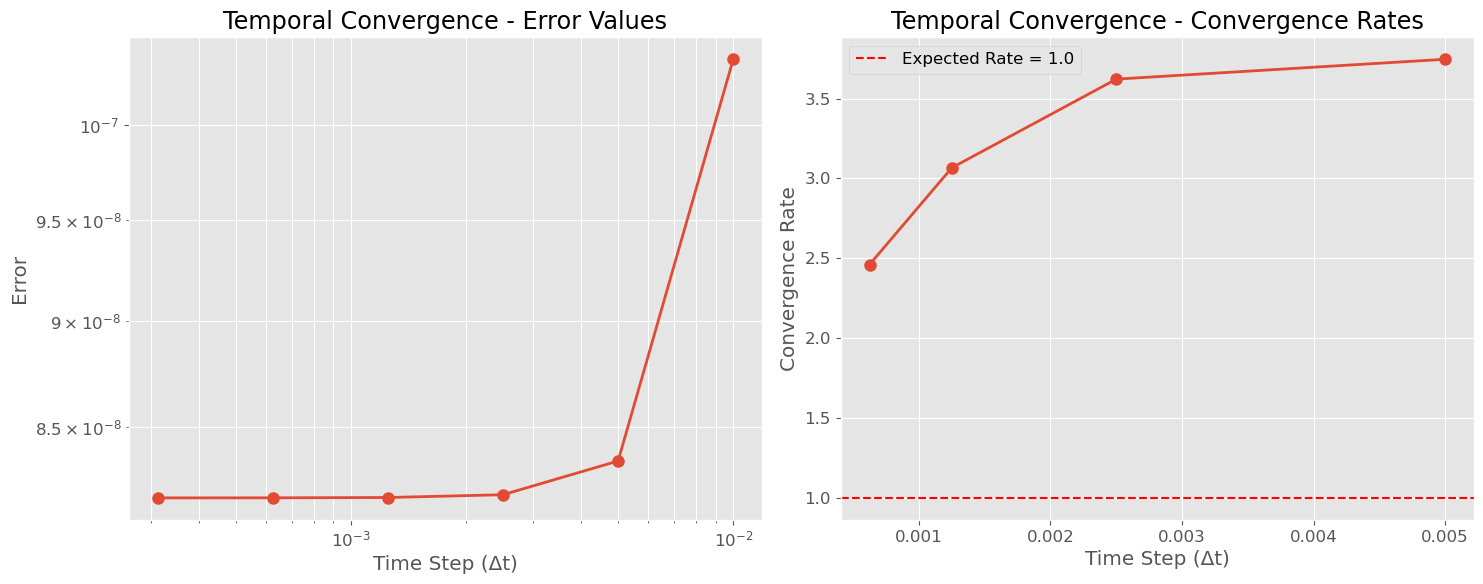

In [6]:
# Set up parameters for temporal convergence study
FIXED_GRID_SIZE = 32  # Use fine grid to minimize spatial error contribution
BASE_DT = 1e-2
REFINEMENT_LEVELS = 6

# Generate dt values (halving)
dt_values = [BASE_DT / (2**i) for i in range(REFINEMENT_LEVELS)]
print(f"Time step values for study: {dt_values}")

# Final simulation time (short to save computation time)
Tf = 0.01

# Initialize storage for results
temporal_errors = []

# Create fixed grid
grid = p1.make_uniform_grid(N=FIXED_GRID_SIZE, M=FIXED_GRID_SIZE)

# Create MMS case
mms_case_for_plot = MMS_CASE_CLASS(grid=grid, model=model)

print("\n=== Temporal Convergence Study ===")
for i, dt in enumerate(dt_values):
    print(f"\nRunning simulation with dt = {dt:.12e}")
    
    # Set up RegHCsTriple infrastructure
    mms_trial = mtu.MMSTrial(
        grid=grid,
        model=model,
        mms_case_cls=MMS_CASE_CLASS,
        field_cls=p1.SemiDiscreteField_RegHCsTriple,
        forcing_terms_cls=p1.ForcingTerms_RegHCsTriple,
        integrator_cls=p1.P_ModifiedEuler_C_Trapezoidal_TimeIntegrator_RegHCsTriple,
        integrator_params={"regularization_factor": REGULARIZATION_FACTOR},
        forcing_terms_params={"regularization_factor": REGULARIZATION_FACTOR},
        field_params={"regularization_factor": REGULARIZATION_FACTOR}
    )
    
    # Run the simulation and collect error
    start_time = time.time()
    error_summary = mms_trial.run_for_errors(Tf=Tf, dt=dt)
    error = error_summary.overall_combined_error
    end_time = time.time()
    
    # Extract the overall combined error
    temporal_errors.append(error_summary.overall_combined_error)
    
    print(f"  Completed in {end_time - start_time:.12f} seconds")
    print(f"  Overall error: {error:.12e}")

# Report on convergence rates
temporal_rates, temporal_success = nbh.report_on_rates(
    errors=temporal_errors,
    expected_rate=2.0,
    tolerance=0.2,
    title="Temporal Convergence Results"
)

# Plot results
nbh.plot_errors_and_rates(
    errors=temporal_errors,
    rates=temporal_rates,
    x_values=dt_values,
    x_label='Time Step (Δt)',
    title='Temporal Convergence',
    expected_rate=1.0
)

# Save results for later reference
temporal_results = {
    'dt_values': dt_values,
    'errors': temporal_errors,
    'rates': temporal_rates,
    'success': temporal_success
}

## Regularization Factor Study

The RegHCsTriple classes use a regularized Heaviside function, which depends on a regularization factor (η). Let's study how different values of η affect the convergence properties.


=== Regularization Factor Study ===

Testing regularization factor η = 10.0
  Completed in 2.403333663940 seconds
  Overall error: 8.179982876369e-08
  Per-variable errors:
    cp: 2.166334925030e-13
    T: 8.179676771432e-08
    cl: 7.070874628589e-10
    cd: 2.836419811360e-11
    cs: 5.288549915545e-14

Testing regularization factor η = 50.0
  Completed in 1.829298257828 seconds
  Overall error: 8.179982920798e-08
  Per-variable errors:
    cp: 2.166334925030e-13
    T: 8.179676771432e-08
    cl: 7.070874628589e-10
    cd: 2.961780734745e-11
    cs: 5.232015116592e-14

Testing regularization factor η = 100.0
  Completed in 1.548384666443 seconds
  Overall error: 8.179982937825e-08
  Per-variable errors:
    cp: 2.166334925030e-13
    T: 8.179676771432e-08
    cl: 7.070874628589e-10
    cd: 3.008439158687e-11
    cs: 5.230873073846e-14

Testing regularization factor η = 200
  Completed in 0.971215248108 seconds
  Overall error: 8.179982942569e-08
  Per-variable errors:
    cp: 2.166

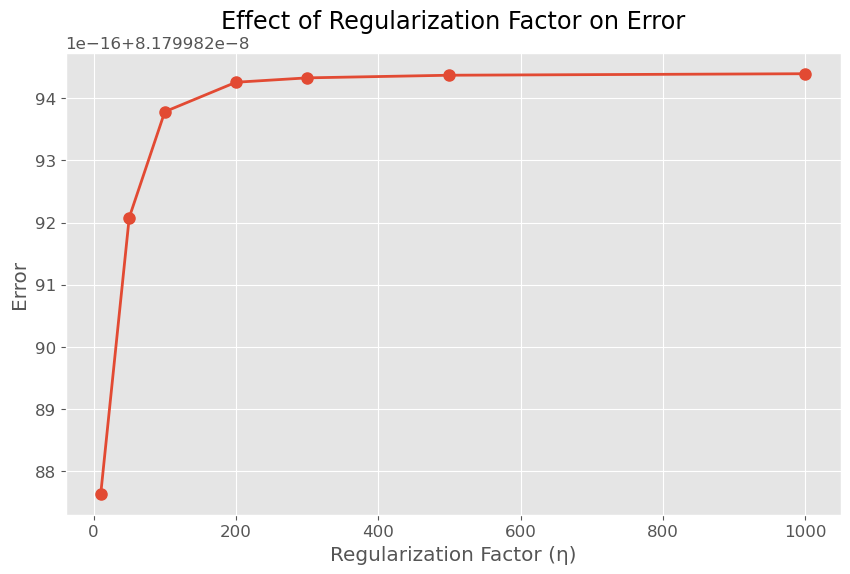

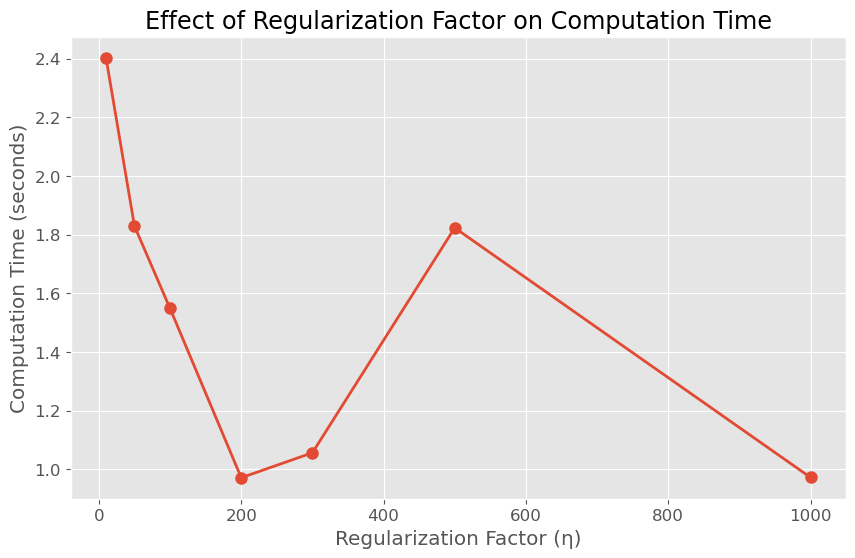

In [7]:
# Set up parameters for regularization factor study
REG_FACTORS = [10.0, 50.0, 100.0, 200, 300, 500, 1000]
FIXED_GRID_SIZE = 32
FIXED_DT = 5e-4
Tf = 0.01  # Short final time

# Initialize storage for results
reg_factor_errors = []
reg_factor_times = []

print("\n=== Regularization Factor Study ===")
for reg_factor in REG_FACTORS:
    print(f"\nTesting regularization factor η = {reg_factor}")
    
    # Create grid
    grid = p1.make_uniform_grid(N=FIXED_GRID_SIZE, M=FIXED_GRID_SIZE)
    
    # Set up RegHCsTriple infrastructure
    mms_trial = mtu.MMSTrial(
        grid=grid,
        model=model,
        mms_case_cls=MMS_CASE_CLASS,
        field_cls=p1.SemiDiscreteField_RegHCsTriple,
        forcing_terms_cls=p1.ForcingTerms_RegHCsTriple,
        integrator_cls=p1.P_ModifiedEuler_C_Trapezoidal_TimeIntegrator_RegHCsTriple,
        integrator_params={"regularization_factor": reg_factor},
        forcing_terms_params={"regularization_factor": reg_factor},
        field_params={"regularization_factor": reg_factor}
    )
    
    # Run the simulation and collect error
    start_time = time.time()
    error_summary = mms_trial.run_for_errors(Tf=Tf, dt=FIXED_DT)
    end_time = time.time()
    run_time = end_time - start_time
    
    # Extract the overall combined error
    error = error_summary.overall_combined_error
    reg_factor_errors.append(error)
    reg_factor_times.append(run_time)
    
    print(f"  Completed in {run_time:.12f} seconds")
    print(f"  Overall error: {error:.12e}")
    print(f"  Per-variable errors:")
    for var, err in error_summary.per_variable_sup_errors.items():
        print(f"    {var}: {err:.12e}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(REG_FACTORS, reg_factor_errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('Regularization Factor (η)')
plt.ylabel('Error')
plt.title('Effect of Regularization Factor on Error')
plt.grid(True)
plt.show()

# Plot computation time
plt.figure(figsize=(10, 6))
plt.plot(REG_FACTORS, reg_factor_times, 'o-', linewidth=2, markersize=8)
plt.xlabel('Regularization Factor (η)')
plt.ylabel('Computation Time (seconds)')
plt.title('Effect of Regularization Factor on Computation Time')
plt.grid(True)
plt.show()

# Save results for later reference
reg_factor_results = {
    'reg_factors': REG_FACTORS,
    'errors': reg_factor_errors,
    'times': reg_factor_times
}

## Summary and Conclusions

This notebook has investigated the convergence properties of the RegHCsTriple infrastructure using the MMSCaseExpSin through:

1. Spatial convergence analysis (varying grid sizes)
2. Temporal convergence analysis (varying time steps)
3. Analysis of the effect of different regularization factors

Verifications:

1. **Spatial Convergence**: Order 2 in the adequate induced norm.

2. **Temporal Convergence**: Order 2 in the adequate induced norm.

3. **Regularization Factor**: As expected, the higher the regularization factor $\eta$, the larger the error, keeping everything else the same. However, even with this increase, errors are essentially stalled around $8.18 \times 10^{-8}$ (see plot).